In [1]:
# Gina McFarland
# COMP 4449 - Capstone
# Midterm Project

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pprint
import joblib
import skimage
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from collections import Counter
from scipy import ndimage

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


### This goal of this project is to perform image classification. The data set contains three sets of images: normal lungs, pneumonia infected lungs, and COVID-19 infected lungs. Four different machine learning models will be analyzed to find the highest accuracy percentage of images correctly classified. 

#### Structure of an Image Classification Task - Preprocessing Steps
https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

"Image Preprocessing - The aim of this process is to improve the image data (features) by suppressing unwanted distortions and enhancement of some important image features so that our Computer Vision models can benefit from this improved data to work on.

Detection of an object - Detection refers to the localization of an object which means the segmentation of the image and identifying the position of the object of interest.

Feature extraction and Training- This is a crucial step wherein statistical or deep learning methods are used to identify the most interesting patterns of the image, features that might be unique to a particular class and that will, later on, help the model to differentiate between different classes. This process where the model learns the features from the dataset is called model training.

Classification of the object - This step categorizes detected objects into predefined classes by using a suitable classification technique that compares the image patterns with the target patterns."

### Read in and view data

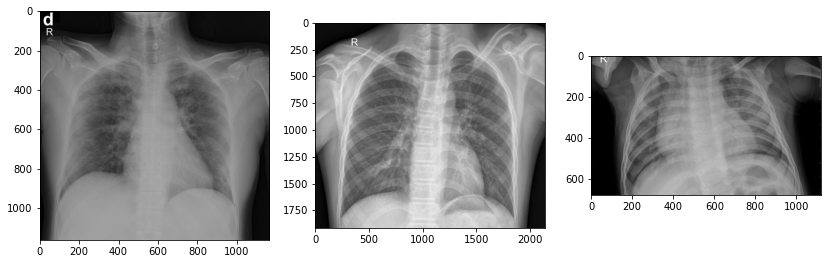

In [4]:
dataroot = 'C:\\Users\Gina\\Documents\\University of Denver\\4449 (Capstone)\\Midterm\\xrays\\'
img_covid     = cv2.imread(dataroot+'COVID19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',0)
img_normal    = cv2.imread(dataroot+'Normal/IM-0011-0001-0001.jpeg',0)
img_pneumonia = cv2.imread(dataroot+'Pneumonia/person1650_virus_2854.jpeg',0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_covid,cmap='gray')  # show the image in grayscale; this is not the default
plt.subplot(1,3,2)
plt.imshow(img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(img_pneumonia,cmap='gray');

Differences between COVID lungs (left), normal lungs (middle), and pneumonia lungs (right) are subtle. The COVID lungs have the most opacity while the pneumonia lungs are slightly lighter and the normal lungs are the most transparent.

Note the different sizes of the images. Resizing all the images to a standard 80 x 80 pixel will be one of the first steps.

### Create dataset

In [5]:
# modified from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) lung images'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
            for file in os.listdir(current_path):
                if (file[-3:] in {'jpg', 'png'}) or (file[-4:] in {'jpeg'}):
                    im = imread(os.path.join(current_path, file), as_gray = True)
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [6]:
include = set(os.listdir(dataroot)) # list dirs for pics
include

{'COVID19', 'Normal', 'Pneumonia'}

#### Create data set from images and resize for standardization

In [7]:
# create dataset

base_name = 'lung_images'
width = 80
  
resize_all(src=dataroot, pklname=base_name, width=width, include=include)

COVID19
Normal
Pneumonia


In [8]:
# load data and print summary
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  602
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80) lung images
image shape:  (80, 80)
labels: ['COV' 'No' 'Pneum']


Counter({'COV': 220, 'No': 234, 'Pneum': 148})

#### View a histogram of image labels; visually see the data imbalance shown in previous result

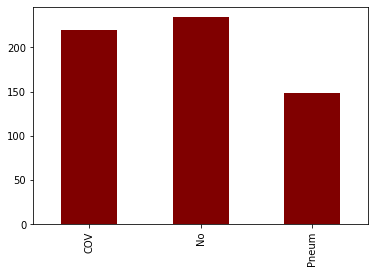

In [9]:
label_counts = Counter(data['label'])
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar', legend=False, color='maroon');

#### View images as loaded into dataset

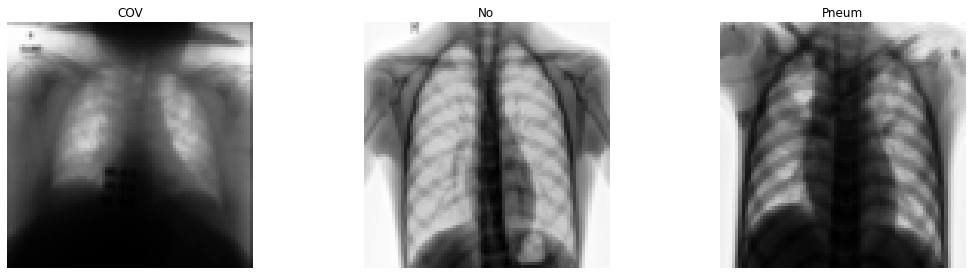

In [10]:
# show example of each group

# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx], cmap='Greys') # use 'Greys' to show in  grayscale; not the default
    ax.axis('off')
    ax.set_title(label)

#### Images are slightly distorted from original pictures, but the reconstitued matrix looks very similar to the picture files.

### Data Preparation

#### Data Description

In [11]:
pd.DataFrame(np.array(data['label'])).describe()

,0
count,602
unique,3
top,No
freq,234


This indicates that there are 602 records, with 3 unique values. The most frequent data is 'No' or normal lungs, with a count of 234.

In [12]:
pd.Series(np.array(data['label'])).value_counts()

No       234
COV      220
Pneum    148
dtype: int64

This indicates there are 234 images of normal lungs, 220 images of lungs with Covid-19, and 148 images of lungs with Pneumonia. The imbalance of the number of lungs with pneumonia may be an issue in the classification task. 

Sample of image as a matrix

In [15]:
data['data'][0]

array([[0.33357475, 0.32585059, 0.35658545, ..., 0.48458416, 0.49176623,
        0.6440686 ],
       [0.06627061, 0.07867302, 0.10656704, ..., 0.41650295, 0.42197002,
        0.59504799],
       [0.01515436, 0.0243757 , 0.02660981, ..., 0.37107427, 0.37280089,
        0.5591654 ],
       ...,
       [0.95162274, 0.95069136, 0.9570466 , ..., 0.8690419 , 0.83609848,
        0.85974611],
       [0.95415969, 0.9528574 , 0.9596131 , ..., 0.88547885, 0.85449823,
        0.87661561],
       [0.95606388, 0.95539292, 0.96233607, ..., 0.9012843 , 0.87240793,
        0.89215804]])

There are 602 items in X, which is a numpy array. Each image has been translated into a matrix. 

In [16]:
np.asarray(data['data']).shape

(602, 80, 80)

The 602 grayscale images are stored in an 80 x 80 2D array

Information about image intensity

In [17]:
np.asarray(data['data']).min(), np.asarray(data['data']).max()

(0.0, 1.0)

In [18]:
np.asarray(data['data']).mean()

0.5033826248622022

The average image intensity is right at the middle of the max and min intensity

#### Techniques to pre-process images for machine learning analysis: Gaussian Blurring and HOG transform

#### Approaching the task

Below is a summary of my research to discover the best steps to take for successful image processing.

Recommended steps for image processing: https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8
1. Resize: Resize all the images into a single shape in order to avoid any future issue related to computation. 
2. Normalize:  In order to avoid brightness, contrast or other illumination effects.
3. Filtering:  In order to take account a few neighboring pixels in stead of taking a single pixel value as the true value of the pixel.

Next, do a HOG-SVM conversion:
https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
'A classic approach to object recognition is HOG-SVM, which stands for Histogram of Oriented Gradients and Support Vector Machines. HOGs are used for feature reduction, in other words: for lowering the complexity of the problem, while maintaining as much variation as possible.

To calculate a HOG, an image is divided into blocks, for example 8 by 8 pixels. For each of these blocks, the magnitude of the gradient in a given number of directions is calculated. For a detailed explanation, we refer to http://www.learnopencv.com/histogram-of-oriented-gradients/'

https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8:
'HOG is a technique for transforming an image to a histogram of gradients and later use the histograms to make a 1D matrix which would be used for training a model.'

### Prior to implementing Gaussian blurring and HOG transform, test the methods on the data and visualize results

#### Test Gaussian filtering / blurring - what is resulting image?

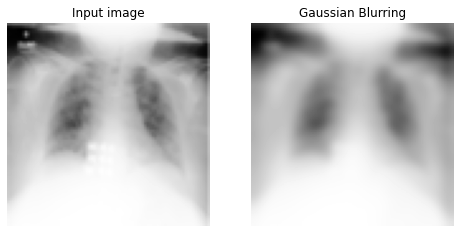

In [19]:
img = ndimage.gaussian_filter(data['data'][0], sigma= 1.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(data['data'][0], cmap=plt.cm.gray)
ax1.set_title('Input image');

ax2.axis('off')
ax2.imshow(img, cmap=plt.cm.gray)
ax2.set_title('Gaussian Blurring')
plt.show()

#### When processed with Guassian blurring and HOG, accuracy went down ~5% for all models with sigma set to 5. Sigma set to 1.5, SVC went up to 93% vs 90% without Gaussian blurring.

Gaussian blurring averages the pixel location but adds a higher weight to the center pixels. The concept is that the average variance of noise is smaller when considering the variance of a single pixel. There must be a fine tuning of the amount of blurring in order to remove noise, but not to remove image gradients. (Collins)

#### Test HOG Transform - What is the resulting image?

COV


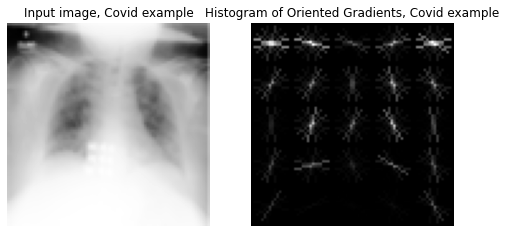

In [20]:
# adapated from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
print(data['label'][0])

fd, hog_image = hog(data['data'][0], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=True) # returns HOG descriptor and HOG image


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(data['data'][0], cmap=plt.cm.gray)
ax1.set_title('Input image, Covid example')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients, Covid example')
plt.show()

Histogram of Oriented Gradients (HOG) is used to feature engineer the data and simplify the image to its most important aspects. The method divides the image into sections, identifies edge pixels and extracts their gradient and orientation. (2020)

### Process images with Gaussian Blurring and HOG transformation

In [21]:
# adapted from: https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8
# HOG Descriptor
# Returns a 1D vector for an image

hog_images = []
hog_features = []
for image in data['data']:
    img = ndimage.gaussian_filter(image, sigma= 1.5) # changed these lines
    fd,hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=True) # returns HOG descriptor and HOG image
    hog_images.append(hog_image)
    hog_features.append(fd)
hog_features = np.array(hog_features)
hog_features.shape

(602, 512)

#### Create train - test split

In [22]:
X = hog_features # modified HOG data
y = np.array(data['label'])

In [23]:
# need to shuffle data prior to train/test/split because it is currently ordered by Covid, 
#then Normal, then Pneumonia

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, # 80% train, 20% test
    shuffle=True,  # shuffles data
    stratify = y,  # create even groupings by class
    random_state=42
)

#### Set shuffle to True since data was read in sequentially; machine learning models will perform better if the data is randomized. Used 'stratify' on the class labels to ensure the three groups are even for train and test. This is one technique to mitigate the data imbalance in the pneumonia images.

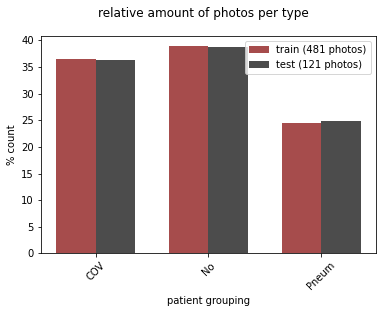

In [24]:
# check train / test split distribution by category
def plot_bar(y, color,loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique)) 
        
    plt.bar(xtemp + n*width, counts,align='center',alpha=.7,color=color,width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('patient grouping')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, color='maroon',loc='left')
plot_bar(y_test, color='black',loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

#### Visualization of data distribution in train and test. With stratify set to 'y', this place the same proportion of each type of image in the image training and test sets.

## Data preprocessing complete -  Model training step

### Classify with KNN Classifier

In [25]:
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier_knn = KNeighborsClassifier(n_neighbors=3)
classifier_knn.fit(X_scaled, y_train)
y_pred_knn = classifier_knn.predict(scaler.transform(X_test))

In [26]:
confusion_matrix(y_pred_knn, y_test)

array([[35,  0,  0],
       [ 8, 43, 10],
       [ 1,  4, 20]], dtype=int64)

In [27]:
test_accuracy_knn = classifier_knn.score(scaler.transform(X_test), y_test)
print(test_accuracy_knn)

0.8099173553719008


In [28]:
print("Classification Report: \n Labels: %s \n Classifier: %s:\n%s\n"
      % (include,classifier_knn, classification_report(y_test, y_pred_knn)))

Classification Report: 
 Labels: {'Pneumonia', 'Normal', 'COVID19'} 
 Classifier: KNeighborsClassifier(n_neighbors=3):
              precision    recall  f1-score   support

         COV       1.00      0.80      0.89        44
          No       0.70      0.91      0.80        47
       Pneum       0.80      0.67      0.73        30

    accuracy                           0.81       121
   macro avg       0.83      0.79      0.80       121
weighted avg       0.84      0.81      0.81       121




We will tune the hyperparameters to see if we can improve model performance.

In [29]:
n_neighbors = list(range(1,30)) # number of neighbors used
p=[1,2] # Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.
n_jobs = [3] # number of processors
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p, n_jobs=n_jobs)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf_knn = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model_knn = clf_knn.fit(X_train,y_train)

In [30]:
#print The value of best hyperparameters
print('Best p:', best_model_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model_knn.best_estimator_.get_params()['n_neighbors'])

Best p: 1
Best n_neighbors: 1


In [31]:
best_knn = KNeighborsClassifier(n_neighbors=1, p = 1)
best_knn.fit(X_scaled, y_train)
y_best_knn = best_knn.predict(scaler.transform(X_test))

confusion_matrix(y_best_knn, y_test)
test_accuracy_knn = classifier_knn.score(scaler.transform(X_test), y_test)
print(test_accuracy_knn)

print("Classification Report: \n Labels: %s \n Classifier: %s:\n%s\n"
      % (include,best_knn, classification_report(y_test, y_best_knn)))

0.8099173553719008
Classification Report: 
 Labels: {'Pneumonia', 'Normal', 'COVID19'} 
 Classifier: KNeighborsClassifier(n_neighbors=1, p=1):
              precision    recall  f1-score   support

         COV       1.00      0.77      0.87        44
          No       0.72      0.89      0.80        47
       Pneum       0.79      0.77      0.78        30

    accuracy                           0.82       121
   macro avg       0.84      0.81      0.82       121
weighted avg       0.84      0.82      0.82       121




Tuning the hyperparameters resulted in a modest 1% gain in accuracy. Final accuracy for KNN is 82%.

### Classify with Random Forest Classifier

In [32]:
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier_rfc = RandomForestClassifier(max_depth = 4, random_state = 0)
classifier_rfc.fit(X_scaled, y_train)
y_pred_rfc = classifier_rfc.predict(scaler.transform(X_test))

In [33]:
confusion_matrix(y_pred_rfc, y_test)

array([[40,  1,  3],
       [ 4, 44,  9],
       [ 0,  2, 18]], dtype=int64)

In [34]:
test_accuracy_rfc = classifier_rfc.score(scaler.transform(X_test), y_test)
print(test_accuracy_rfc)

0.8429752066115702


In [35]:
print("Classification Report: \n Labels: %s \n Classifier: %s:\n%s\n"
      % (include,classifier_rfc, classification_report(y_test, y_pred_rfc)))

Classification Report: 
 Labels: {'Pneumonia', 'Normal', 'COVID19'} 
 Classifier: RandomForestClassifier(max_depth=4, random_state=0):
              precision    recall  f1-score   support

         COV       0.91      0.91      0.91        44
          No       0.77      0.94      0.85        47
       Pneum       0.90      0.60      0.72        30

    accuracy                           0.84       121
   macro avg       0.86      0.82      0.83       121
weighted avg       0.85      0.84      0.84       121




#### Tune the hyperparameters

In [36]:
n_estimators = list(range(50, 150)) # default is 100 - this is number of decision trees created
max_depth = [None,3, 4,5,6,7,8,9,10] # None expands nodes until pure
n_jobs = [3] # number of processors

hyperparameters = dict(n_estimators = n_estimators, max_depth = max_depth, n_jobs=n_jobs)
rf_2 = RandomForestClassifier(random_state=0)
clf_best_rf = GridSearchCV(rf_2, hyperparameters, cv=10)
best_model_rf = clf_best_rf.fit(X_train,y_train)

In [37]:
# print The value of best hyperparameters
print('Best n_estimators:', best_model_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model_rf.best_estimator_.get_params()['max_depth'])

Best n_estimators: 134
Best max_depth: 10


A previous run of hyperparameter tuning came up with a different result (although the random seed was set, so the results should have been consistent). The above n_estimators = 134 and max_depth = 10 resulted in an accuracy of 89% while the previous hyperparameter tuning result (n_estimators=57 and max_depth = 8) resulted in a 90% accuracy which is shown below.

In [61]:
best_rf = RandomForestClassifier(n_estimators=57, max_depth=8, n_jobs=3, random_state=0)
best_rf.fit(X_scaled, y_train)
y_best_rf = best_rf.predict(scaler.transform(X_test))

confusion_matrix(y_best_rf, y_test)
test_accuracy_rf = classifier_knn.score(scaler.transform(X_test), y_test)
print(test_accuracy_rf)

print("Classification Report: \n Labels: %s \n Classifier: %s:\n%s\n"
      % (include,best_rf, classification_report(y_test, y_best_rf)))

0.8099173553719008
Classification Report: 
 Labels: {'Pneumonia', 'Normal', 'COVID19'} 
 Classifier: RandomForestClassifier(max_depth=8, n_estimators=57, n_jobs=3, random_state=0):
              precision    recall  f1-score   support

         COV       0.91      0.98      0.95        44
          No       0.87      0.96      0.91        47
       Pneum       0.95      0.70      0.81        30

    accuracy                           0.90       121
   macro avg       0.91      0.88      0.89       121
weighted avg       0.91      0.90      0.90       121




Random Forest sccuracy improved from 84% to 90% with hyperparameter tuning.

### Classify with Support Vector Classifier

In [39]:
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier_svc = SVC(gamma = 'auto', random_state = 0)
classifier_svc.fit(X_scaled, y_train)
y_pred_svc = classifier_svc.predict(scaler.transform(X_test))

In [40]:
confusion_matrix(y_pred_svc, y_test)

array([[43,  1,  0],
       [ 1, 44,  4],
       [ 0,  2, 26]], dtype=int64)

In [41]:
test_accuracy_svc = classifier_svc.score(scaler.transform(X_test), y_test)
print(test_accuracy_svc)

0.9338842975206612


In [42]:
print("Classification Report: \n Labels: %s \n Classifier: %s:\n%s\n"
      % (include,classifier_svc, classification_report(y_test, y_pred_svc)))

Classification Report: 
 Labels: {'Pneumonia', 'Normal', 'COVID19'} 
 Classifier: SVC(gamma='auto', random_state=0):
              precision    recall  f1-score   support

         COV       0.98      0.98      0.98        44
          No       0.90      0.94      0.92        47
       Pneum       0.93      0.87      0.90        30

    accuracy                           0.93       121
   macro avg       0.93      0.93      0.93       121
weighted avg       0.93      0.93      0.93       121




#### Tune the SVC hyperparameters

In [43]:
kernel = ['linear','rbf','poly'] # type of hyperplane
gamma = ['auto', 'scale'] # higher gammas fit training data more closely
c = [1, 2,3,4,5,10, 100] # penalty of error term
degree = list(range(0,7)) # degree of polynomial; only used for poly

hyperparameters = dict(kernel=kernel, gamma=gamma, C=c, degree=degree)
svc_2 = SVC(random_state=0)
clf_best_svc = GridSearchCV(svc_2, hyperparameters, cv=10)
best_model_svc = clf_best_svc.fit(X_train,y_train)

In [44]:
# print The value of best hyperparameters
print('Best kernel:', best_model_svc.best_estimator_.get_params()['kernel'])
print('Best gamma:', best_model_svc.best_estimator_.get_params()['gamma'])
print('Best C:', best_model_svc.best_estimator_.get_params()['C'])
print('Best degree:', best_model_svc.best_estimator_.get_params()['degree'])

Best kernel: rbf
Best gamma: scale
Best C: 1
Best degree: 0


Degree parameter ignored by the algorithm since 'poly' not chosen as the kernel.

In [45]:
best_svc = SVC(kernel = 'rbf', gamma = 'scale', C = 1)
best_svc.fit(X_scaled, y_train)
y_best_svc = best_svc.predict(scaler.transform(X_test))

confusion_matrix(y_best_svc, y_test)
test_accuracy_svc = best_svc.score(scaler.transform(X_test), y_test)
print(test_accuracy_svc)

print("Classification Report: \n Labels: %s \n Classifier: %s:\n%s\n"
      % (include,best_svc, classification_report(y_test, y_best_svc)))

0.9338842975206612
Classification Report: 
 Labels: {'Pneumonia', 'Normal', 'COVID19'} 
 Classifier: SVC(C=1):
              precision    recall  f1-score   support

         COV       0.98      0.98      0.98        44
          No       0.90      0.94      0.92        47
       Pneum       0.93      0.87      0.90        30

    accuracy                           0.93       121
   macro avg       0.93      0.93      0.93       121
weighted avg       0.93      0.93      0.93       121




There was no improvement in SVC from tuning the hyperparameters. The model defaults were the best parameters for the data, other than degree which was 0 in the best model rather than the default of 3. This degree parameter is ignored in the chosen kernel, 'rbf', as the degree parameter is only meaningful to the 'poly' kernel. Accuray remained at 93%.

### Classify with Neural Network (MLP)

In [46]:
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier_mlp = MLPClassifier(solver='lbfgs',alpha=1e-5, random_state=0)
classifier_mlp.fit(X_scaled, y_train)
y_pred_mlp = classifier_mlp.predict(scaler.transform(X_test))

In [47]:
confusion_matrix(y_pred_mlp, y_test)

array([[42,  2,  1],
       [ 2, 42,  6],
       [ 0,  3, 23]], dtype=int64)

In [48]:
test_accuracy_mlp = classifier_mlp.score(scaler.transform(X_test), y_test)
print(test_accuracy_mlp)

0.8842975206611571


In [49]:
print("Classification Report: \n Labels: %s \n Classifier: %s:\n%s\n"
      % (include,classifier_mlp, classification_report(y_test, y_pred_mlp)))

Classification Report: 
 Labels: {'Pneumonia', 'Normal', 'COVID19'} 
 Classifier: MLPClassifier(alpha=1e-05, random_state=0, solver='lbfgs'):
              precision    recall  f1-score   support

         COV       0.93      0.95      0.94        44
          No       0.84      0.89      0.87        47
       Pneum       0.88      0.77      0.82        30

    accuracy                           0.88       121
   macro avg       0.89      0.87      0.88       121
weighted avg       0.89      0.88      0.88       121




#### Tune Neural Network hyperparameters

In [50]:
activation = ['identity', 'logistic', 'tanh', 'relu'] # activation function
solver = ['lbfgs','sgd','adam'] # solver for weight optimization
alpha = [0.0001, 0.001, 0.01, 0.1] # L2 penalty parameter
learning_rate = ['constant', 'invscaling', 'adaptive'] # for wt updates

hyperparameters = dict(activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate)
mlp_2 = MLPClassifier(random_state=0, max_iter=1500) # not solving at default = 200 or 500 or 1000
clf_mlp_best = GridSearchCV(mlp_2, hyperparameters, cv=10)
best_model_mlp = clf_mlp_best.fit(X_train,y_train)

C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\an

C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\an

C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\an

C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\an

C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\an

C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\anaconda3\envs\Capstone\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Gina\an

After increasing the max_iter parameter from the default of 200 to 500, 1000, and eventually 1500, some of the models did not converge. However, some models did converge and those were used for the remainder of the analysis.

In [51]:
# print The value of best hyperparameters
print('Best activation:', best_model_mlp.best_estimator_.get_params()['activation'])
print('Best solver:', best_model_mlp.best_estimator_.get_params()['solver'])
print('Best alpha:', best_model_mlp.best_estimator_.get_params()['alpha'])
print('Best learning rate:', best_model_mlp.best_estimator_.get_params()['learning_rate'])

Best activation: relu
Best solver: sgd
Best alpha: 0.0001
Best learning rate: constant


In [63]:
best_mlp = MLPClassifier(activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant', random_state=0, max_iter=500)
best_mlp.fit(X_scaled, y_train)
y_best_mlp = best_mlp.predict(scaler.transform(X_test))

confusion_matrix(y_best_mlp, y_test)
test_accuracy_mlp = best_mlp.score(scaler.transform(X_test), y_test)
print(test_accuracy_mlp)

print("Classification Report: \n Labels: %s \n Classifier: %s:\n%s\n"
      % (include,best_mlp, classification_report(y_test, y_best_mlp)))

0.8925619834710744
Classification Report: 
 Labels: {'Pneumonia', 'Normal', 'COVID19'} 
 Classifier: MLPClassifier(max_iter=500, random_state=0, solver='sgd'):
              precision    recall  f1-score   support

         COV       0.95      0.95      0.95        44
          No       0.84      0.89      0.87        47
       Pneum       0.89      0.80      0.84        30

    accuracy                           0.89       121
   macro avg       0.89      0.88      0.89       121
weighted avg       0.89      0.89      0.89       121




The model did not converge at the default 200 iterations, but at 500 iterations, this optimized model converged.

The accuracy increased a modest 1% from 88% to 89%.

### Summary

#### Prepare to visualize outputs and perform analysis on results

In [53]:
# create dictionaries with the output for each model
knn_output = classification_report(y_test, y_pred_knn, output_dict=True)
    
rf_output = classification_report(y_test, y_best_rf, output_dict=True)

svc_output = classification_report(y_test, y_best_svc, output_dict=True)

mlp_output = classification_report(y_test, y_best_mlp, output_dict=True)

In [54]:
accuracies = {'Ave Radiologist': 0.74,'KNN': knn_output['accuracy'], 'Random Forest':rf_output['accuracy'], 'SVC': svc_output['accuracy'], 'MLP': mlp_output['accuracy']}
accuracies

{'Ave Radiologist': 0.74,
 'KNN': 0.8099173553719008,
 'Random Forest': 0.9008264462809917,
 'SVC': 0.9338842975206612,
 'MLP': 0.8925619834710744}

### Create a bubble plot for accuracies

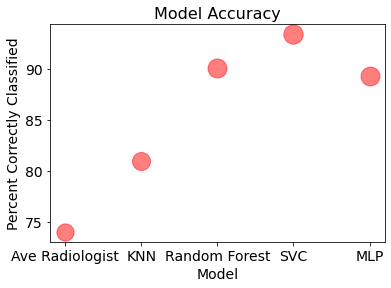

In [55]:
axes = plt.gca()
for key,value in accuracies.items():
    plt.scatter(x = key, y=value*100,s=value*400, c='red',alpha=0.5)

plt.title("Model Accuracy",fontsize=16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Percent Correctly Classified', fontsize=14)
plt.show()

#### Since the accuracies are very close, it is difficult to visually see the difference in the sizes of the points on the bubble plot. However, the size does vary by the percentage of images correctly classified.

### Print output for visual inspection to check visualization output

In [56]:
print(knn_output)
print()
print(mlp_output)
print()
print(svc_output)
print()
print(rf_output)

{'COV': {'precision': 1.0, 'recall': 0.7954545454545454, 'f1-score': 0.8860759493670886, 'support': 44}, 'No': {'precision': 0.7049180327868853, 'recall': 0.9148936170212766, 'f1-score': 0.7962962962962963, 'support': 47}, 'Pneum': {'precision': 0.8, 'recall': 0.6666666666666666, 'f1-score': 0.7272727272727272, 'support': 30}, 'accuracy': 0.8099173553719008, 'macro avg': {'precision': 0.8349726775956284, 'recall': 0.7923382763808294, 'f1-score': 0.803214990978704, 'support': 121}, 'weighted avg': {'precision': 0.835794607776724, 'recall': 0.8099173553719008, 'f1-score': 0.811830161291402, 'support': 121}}

{'COV': {'precision': 0.9545454545454546, 'recall': 0.9545454545454546, 'f1-score': 0.9545454545454546, 'support': 44}, 'No': {'precision': 0.84, 'recall': 0.8936170212765957, 'f1-score': 0.8659793814432989, 'support': 47}, 'Pneum': {'precision': 0.8888888888888888, 'recall': 0.8, 'f1-score': 0.8421052631578948, 'support': 30}, 'accuracy': 0.8925619834710744, 'macro avg': {'precision

#### Create bar plots to display precision and recall results

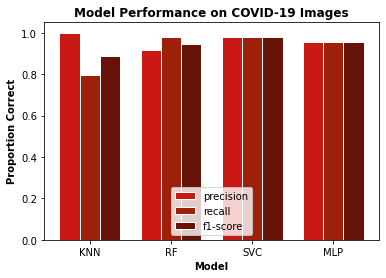

In [57]:
barWidth = 0.25 # barwidth

# bar heights
cov_precision = [knn_output['COV']['precision'], rf_output['COV']['precision'], svc_output['COV']['precision'],mlp_output['COV']['precision']]
cov_recall = [knn_output['COV']['recall'], rf_output['COV']['recall'], svc_output['COV']['recall'],mlp_output['COV']['recall']]
cov_f1 =  [knn_output['COV']['f1-score'], rf_output['COV']['f1-score'], svc_output['COV']['f1-score'],mlp_output['COV']['f1-score']]

 
# Set position of bar on X axis
r1 = np.arange(len(cov_precision))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, cov_precision, color='#CA1814', width=barWidth, edgecolor='white', label='precision')
plt.bar(r2, cov_recall, color='#9D200B', width=barWidth, edgecolor='white', label='recall')
plt.bar(r3, cov_f1, color='#651407', width=barWidth, edgecolor='white', label='f1-score')
 
# Add xticks on the middle of the group bars
plt.xlabel('COVID-19', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(cov_precision))], ['KNN', 'RF', 'SVC', 'MLP'])
plt.xlabel('Model')
plt.ylabel('Proportion Correct', fontweight='bold')
plt.title('Model Performance on COVID-19 Images', fontweight='bold')
 
# Create legend & Show graphic
plt.legend(loc='lower center')
plt.show()

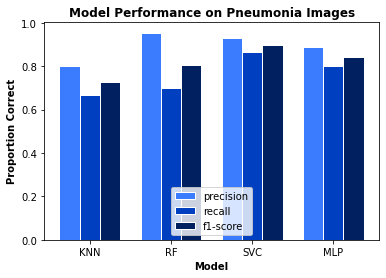

In [58]:
barWidth = 0.25 # barwidth

# bar heights

pn_precision = [knn_output['Pneum']['precision'], rf_output['Pneum']['precision'], svc_output['Pneum']['precision'],mlp_output['Pneum']['precision']]
pn_recall = [knn_output['Pneum']['recall'], rf_output['Pneum']['recall'], svc_output['Pneum']['recall'],mlp_output['Pneum']['recall']]
pn_f1 =  [knn_output['Pneum']['f1-score'], rf_output['Pneum']['f1-score'], svc_output['Pneum']['f1-score'],mlp_output['Pneum']['f1-score']]

 
# Set position of bar on X axis
r1 = np.arange(len(pn_precision))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, pn_precision, color='#3B7CFF', width=barWidth, edgecolor='white', label='precision')
plt.bar(r2, pn_recall, color='#0040C0', width=barWidth, edgecolor='white', label='recall')
plt.bar(r3, pn_f1, color='#002060', width=barWidth, edgecolor='white', label='f1-score')
 
# Add xticks on the middle of the group bars
plt.xlabel('Pneumonia', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(cov_precision))], ['KNN', 'RF', 'SVC', 'MLP'])
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Proportion Correct', fontweight='bold')
plt.title('Model Performance on Pneumonia Images',fontweight='bold')
 
# Create legend & Show graphic
plt.legend(loc='lower center')
plt.show()

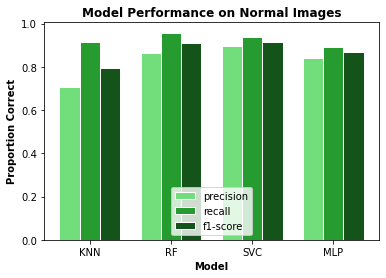

In [59]:
barWidth = 0.25 # barwidth

# bar heights
no_precision = [knn_output['No']['precision'], rf_output['No']['precision'], svc_output['No']['precision'],mlp_output['No']['precision']]
no_recall = [knn_output['No']['recall'], rf_output['No']['recall'], svc_output['No']['recall'],mlp_output['No']['recall']]
no_f1 =  [knn_output['No']['f1-score'], rf_output['No']['f1-score'], svc_output['No']['f1-score'],mlp_output['No']['f1-score']]

# Set position of bar on X axis
r1 = np.arange(len(no_precision))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, no_precision, color='#71DD7B', width=barWidth, edgecolor='white', label='precision')
plt.bar(r2, no_recall, color='#259B30', width=barWidth, edgecolor='white', label='recall')
plt.bar(r3, no_f1, color='#14541A', width=barWidth, edgecolor='white', label='f1-score')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(cov_precision))], ['KNN', 'RF', 'SVC', 'MLP'])
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Proportion Correct', fontweight='bold')
plt.title('Model Performance on Normal Images',fontweight='bold')
 
# Create legend & Show graphic
plt.legend(loc='lower center')
plt.show()

The graphs above show a comparison of how the models performed across the different types of images, COVID-19, normal, and pneumonia by the metrics of precision, recall, and f1-score. Precision is a measure of what proportion of images that were selected as a type of image were classified correctly. Recall considers of all images in each group in the data set, how many were correctly found to be each type. F1-score is a combination of these two measures. All of the models performed the best on the COVID-19 images. This is logical because the COVID images had the most distinguishing characteristics with the deep opacity of the lung images. The models performed less well on the normal lung images and performed the least on the pneumonia images. This may be due to the number of similarities in the images or may be due to the underrepresentation of the pneumonia images.  

### Summary

Further research on this topic would include adjusting the datasets to have balanced datasets in each category. The 41% fewer pneumonia images may have caused lower accuracies. Imbalanced datasets are problematic for MLP, SVC, and KNN. Random Forest is more tolerant of imbalanced datasets. 
	Another possible variation of this analysis would be to not perform the Histogram of Oriented Gradients (HOG) transformation on the data. SVMs trained on HOG features are known to pair well. (2014) Perhaps without this preprocessing step, the other algorithms may have had a better performance. 
Additionally, Convolutional Neural Networks (CNN) would be added for study. A study was performed using CNN for pneumonia detection and achieved a remarkable 98.4% accuracy rate. (Hashmi, 2020) CNNs were specifically designed to map image data and are the standard model for image predictions. (Brownlee, 2019) 
	The results of this analysis show that machine learning models have tremendous promise to augment the field of radiology and improve diagnostic imaging classification.
